In [1616]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings
import warnings
warnings.filterwarnings('ignore')

In [1617]:
ci = pd.read_csv('data/consumer-index.csv')
prices = pd.read_csv('data/producer-price-global.csv')
xchange = pd.read_csv('data/exchange-rates.csv')


In [1618]:
def print_heading(data):
  print('-'*60)
  print(data.upper())
  print('-'*60)

In [1619]:
prices

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description
0,PP,Producer Prices,8,Albania,5530,Producer Price (LCU/tonne),1253.02,"Onions and shallots, dry (excluding dehydrated)",2010,2010,7001,January,LCU,34000.0,A,Official figure
1,PP,Producer Prices,8,Albania,5530,Producer Price (LCU/tonne),1253.02,"Onions and shallots, dry (excluding dehydrated)",2010,2010,7002,February,LCU,51000.0,A,Official figure
2,PP,Producer Prices,8,Albania,5530,Producer Price (LCU/tonne),1253.02,"Onions and shallots, dry (excluding dehydrated)",2010,2010,7003,March,LCU,69000.0,A,Official figure
3,PP,Producer Prices,8,Albania,5530,Producer Price (LCU/tonne),1253.02,"Onions and shallots, dry (excluding dehydrated)",2010,2010,7004,April,LCU,69000.0,A,Official figure
4,PP,Producer Prices,8,Albania,5530,Producer Price (LCU/tonne),1253.02,"Onions and shallots, dry (excluding dehydrated)",2010,2010,7005,May,LCU,53000.0,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27623,PP,Producer Prices,716,Zimbabwe,5530,Producer Price (LCU/tonne),111.00,Wheat,2017,2017,7009,September,LCU,500.0,A,Official figure
27624,PP,Producer Prices,716,Zimbabwe,5530,Producer Price (LCU/tonne),111.00,Wheat,2017,2017,7010,October,LCU,500.0,A,Official figure
27625,PP,Producer Prices,716,Zimbabwe,5530,Producer Price (LCU/tonne),111.00,Wheat,2017,2017,7011,November,LCU,500.0,A,Official figure
27626,PP,Producer Prices,716,Zimbabwe,5530,Producer Price (LCU/tonne),111.00,Wheat,2017,2017,7012,December,LCU,500.0,A,Official figure


In [1620]:
ITEM = 'Wheat'

In [1621]:

class DataProcesser:

    def __init__(self, df):
        self.df = df
        self.stats = None

    def subset_data(self, item, country, item_col='Item', area_col='Area'):       
        self.df = self.df[(self.df[item_col] == item) & (self.df[area_col] == country)]
       
        return self

    def convert_to_date(self, year_col='Year', month_col='Months'):
        self.df[year_col] = self.df[year_col].astype(str)
        self.df[month_col] = self.df[month_col].astype(str)
        self.df['Date'] = pd.to_datetime(self.df[year_col] + '-' + self.df[month_col])
        return self

    def get_date_and_value(self, date_col='Date', value_col='Value'):
        self.df = self.df[[date_col, value_col]].set_index(date_col)
        mean = self.df.describe().loc['mean'][0]
        std = self.df.describe().loc['std'][0]

        self.stats = {
            'mean' : mean,
            'std' : std
            }           
        
        return self
    
class DataManager:
    def __init__(self):
        self.data_processors = {}

    def process_data_for_country(self, raw_data, country, item=ITEM):
        dp = DataProcesser(raw_data)
        dp.subset_data(item, country).convert_to_date().get_date_and_value()
        self.data_processors[country] = dp
        return dp  # Optionally return the DataProcesser instance

    def get_data_processor(self, country):
        return self.data_processors[country]
        
    def get_all_dataframes(self):
         return [{country: processor.df} for country, processor in self.data_processors.items()]




# EUROPE

In [1622]:
# Usage example:
data_manager = DataManager()

# Process and store DataProcesser instances
germany_dp = data_manager.process_data_for_country(prices, 'Germany')
belgium_dp = data_manager.process_data_for_country(prices, 'Belgium')
spain_dp = data_manager.process_data_for_country(prices, 'Spain')
italy_dp = data_manager.process_data_for_country(prices, 'Italy')



germany_wheat_prices= data_manager.get_data_processor('Germany').df
belgium_wheat_prices = data_manager.get_data_processor('Belgium').df
spain_wheat_prices = data_manager.get_data_processor('Spain').df
italy_wheat_prices = data_manager.get_data_processor('Italy').df


In [1623]:
germany_dp.stats['mean']

190.83402777777778

In [1624]:
import plotly.graph_objects as go

def plot_lines(dfs, title, xlabel, ylabel):
    # Create a figure
    fig = go.Figure()

    # Add traces for each country
    for country, df in dfs.items():
        mean = df['Value'].mean()
        legend_name = f"{country} (mean: {mean:.2f})"
        fig.add_trace(go.Scatter(x=df.index, y=df['Value'], mode='lines', name=country))

    # Update layout with title and axis labels
    fig.update_layout(
        title={'text': title, 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        font=dict(size=15),
        legend_title="Country",
        margin=dict(l=20, r=20, t=40, b=20)
    )

    
    # Show plot
    fig.show()

all_wheat_prices = data_manager.get_all_dataframes()
# Usage:
all_data = {}
for country_data in all_wheat_prices:
    for country, df in country_data.items():
        all_data[country] = df

# Note: Adjust the 'Value' column name if your dataframe has a different column for values
plot_lines(all_data, f'Trend of {ITEM} Prices Over Time in Europe', 'Year', f'{ITEM} Prices LCU/Tonne - EURO')

In [1625]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_decomposition(decomposition, country):
    # Create subplots: 2 rows, 2 cols
    fig = make_subplots(rows=2, cols=2, subplot_titles=('Observed', 'Trend', 'Seasonality', 'Residual'))

    # Observed
    fig.add_trace(
        go.Scatter(x=decomposition.observed.index, y=decomposition.observed, name='Observed',
                   line=dict(color='#0000ff', width=1.5)),
        row=1, col=1
    )

    # Trend
    fig.add_trace(
        go.Scatter(x=decomposition.trend.index, y=decomposition.trend, name='Trend',
                   line=dict(color='#0000ff', width=1.5)),
        row=1, col=2
    )

    # Seasonality
    fig.add_trace(
        go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, name='Seasonality',
                   line=dict(color='#0000ff', width=1.5)),
        row=2, col=1
    )

    # Residual
    fig.add_trace(
        go.Scatter(x=decomposition.resid.index, y=decomposition.resid, name='Residual',
                   line=dict(color='#0000ff', width=1.5)),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(height=800, width=1000, title_text=f"Time Series Decomposition - {country}",
                      title_font_size=30, showlegend=False)

    # Update xaxes and yaxes
    fig.update_xaxes(title_text="Time")
    fig.update_yaxes(title_text="Value")

    fig.show()# plot seasonal decomposition
 


## Germany - Seasonal decomposition

In [1626]:
seasonal_decompose = seasonal_decompose(germany_wheat_prices, model='additive')
plot_decomposition(seasonal_decompose, 'Germany')   

In [1627]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

def perform_adfuller_test(series):
    dftest = adfuller(series, autolag='AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

#Usage:
print_heading('ADF Test for Germany Wheat Prices')
perform_adfuller_test(germany_wheat_prices['Value'])


------------------------------------------------------------
ADF TEST FOR GERMANY WHEAT PRICES
------------------------------------------------------------
1. ADF :  -0.21108363556987864
2. P-Value :  0.9371875175556861
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 135
5. Critical Values :
	 1% :  -3.479742586699182
	 5% :  -2.88319822181578
	 10% :  -2.578319684499314


In [1628]:
class Preprocess_data:
  def __init__(self, df):
    self.df = df

  def differencing(self, interval):
    self.df = self.df.diff(interval)
    return self.df.dropna()
  
  def log_transform(self, column):
    self.df = np.log(self.df[column])
    return self

In [1629]:
germany_wheat_prices['Value'] = Preprocess_data(germany_wheat_prices) \
                                .log_transform('Value') \
                                .differencing(interval=1)

In [1630]:
germany_wheat_prices = germany_wheat_prices.dropna()
print_heading('ADF Test for Germany Wheat Prices after differencing and log transformation')
perform_adfuller_test(germany_wheat_prices)

------------------------------------------------------------
ADF TEST FOR GERMANY WHEAT PRICES AFTER DIFFERENCING AND LOG TRANSFORMATION
------------------------------------------------------------
1. ADF :  -5.155000811736372
2. P-Value :  1.0855554665065604e-05
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 135
5. Critical Values :
	 1% :  -3.479742586699182
	 5% :  -2.88319822181578
	 10% :  -2.578319684499314


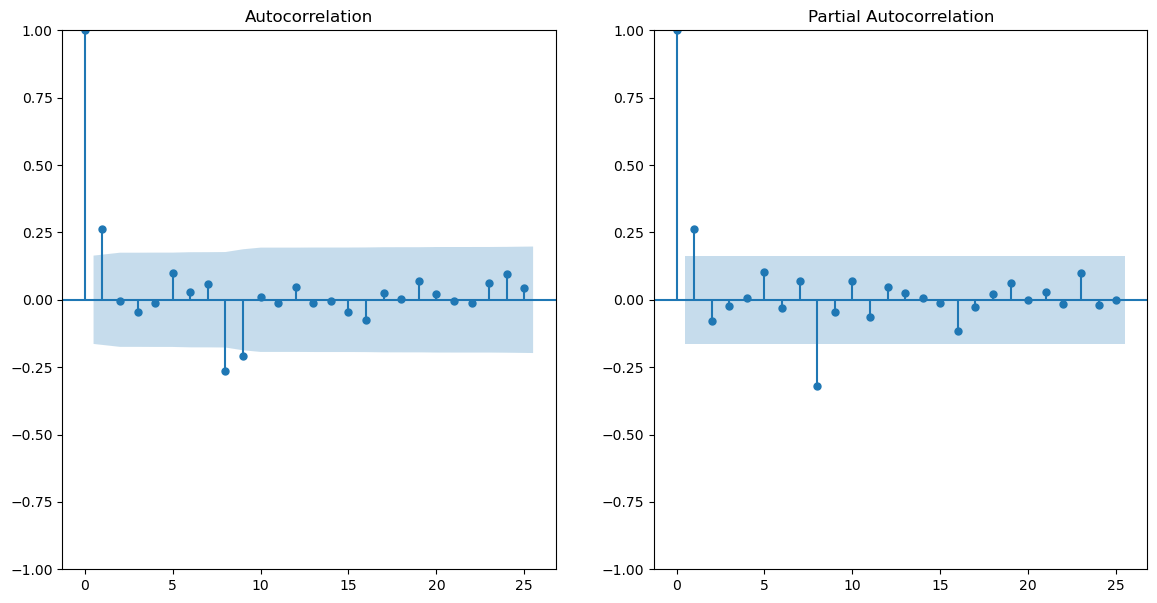

In [1631]:
#plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    plot_acf(series, lags=lags, ax=ax[0])
    plot_pacf(series, lags=lags, ax=ax[1])
    plt.show()

#Usage:
plot_acf_pacf(germany_wheat_prices['Value'], 25)

In [1632]:
def generate_predictions(last_date_in_data, pred_future, periods,  country):
    if isinstance(last_date_in_data, str):
        last_date_in_data = pd.to_datetime(last_date_in_data)

    # Generate a date range starting the first day of the next month after last_date_in_data
    # 'MS' stands for month start frequency
    future_dates = pd.date_range(start=last_date_in_data + pd.offsets.MonthBegin(1), periods=periods, freq='MS')
    # Create the predictions DataFrame with the pred_future list
    predictions = pd.DataFrame(pred_future, columns=['Predicted'])
    # Assign these dates as the index to the predictions DataFrame
    predictions.index = future_dates
    predictions.index.name = 'Date'

    predictions = (predictions["Predicted"] * germany_dp.stats['std'])  + germany_dp.stats['mean']

    return predictions

In [1633]:
X = germany_wheat_prices['Value'].values

In [1634]:
train = X[:len(X)-7]
test = X[len(X)-7:]

model_germany = AutoReg(train, lags=25).fit()

print(model_germany.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  136
Model:                    AutoReg(25)   Log Likelihood                 190.724
Method:               Conditional MLE   S.D. of innovations              0.043
Date:                Mon, 12 Feb 2024   AIC                           -327.447
Time:                        16:46:14   BIC                           -254.290
Sample:                            25   HQIC                          -297.770
                                  136                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.004      0.871      0.384      -0.005       0.012
y.L1           0.3723      0.095      3.928      0.000       0.187       0.558
y.L2          -0.0611      0.101     -0.604      0.5

In [1635]:
pred_germany = model_germany.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

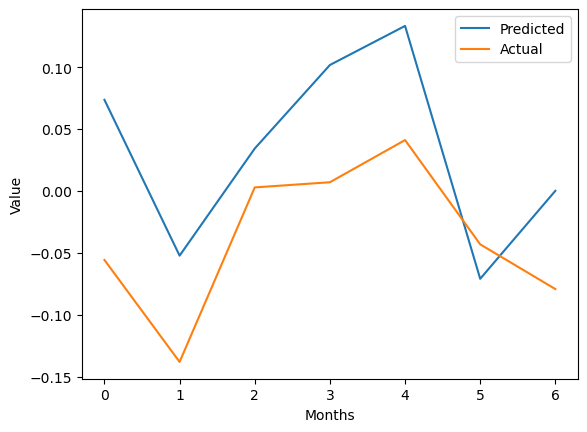

In [1636]:
# import pyplot
from matplotlib import pyplot
pyplot.plot(pred_germany, label='Predicted')
pyplot.plot(test, label='Actual')

pyplot.xlabel('Months')
pyplot.ylabel('Value')

pyplot.legend()

In [1638]:
# Calculate the mean squared erro
from sklearn.metrics import mean_squared_error

def rmse_calc(x, y):  
  return np.sqrt(mean_squared_error(x, y))

rmse = rmse_calc(test, pred_germany)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.084


In [1639]:
# future prediction
pred_future_germany = model_germany.predict(start=len(X)+1, end=len(X)+24, dynamic=False)
print("The future prediction for the next 7 days is:")
print(pred_future_germany)
print("Numbeer of predictions made: ", len(pred_future_germany))

The future prediction for the next 7 days is:
[-0.06178072  0.08962916  0.13135494  0.02554736 -0.04953827  0.07930706
  0.09171101 -0.05538782  0.17622449  0.10735425 -0.06162082  0.03773314
  0.12219533  0.0451184   0.00083656  0.1865561  -0.00647937 -0.08392302
  0.15288643  0.08262014 -0.01396911  0.07304067  0.13825747 -0.07521615]
Numbeer of predictions made:  24


In [1640]:
last_date_in_data = germany_wheat_prices.index.max()

In [1641]:
predictions_germany = generate_predictions(last_date_in_data, pred_future_germany, 24, 'Germany')

# Belgium

In [1602]:
belgium_wheat_prices = belgium_wheat_prices.dropna()
print_heading('ADF Test for for Spain Wheat Prices')
perform_adfuller_test(belgium_wheat_prices['Value'])

------------------------------------------------------------
ADF TEST FOR FOR SPAIN WHEAT PRICES
------------------------------------------------------------
1. ADF :  -1.1561112330217336
2. P-Value :  0.6921850782169459
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 120
5. Critical Values :
	 1% :  -3.486055829282407
	 5% :  -2.8859430324074076
	 10% :  -2.5797850694444446


In [1650]:
belgium_wheat_prices['Value'] = Preprocess_data(belgium_wheat_prices) \
                                .log_transform('Value') \
                                .differencing(interval=1)

In [1651]:
belgium_wheat_prices = belgium_wheat_prices.dropna()
print_heading('ADF Test for for Spain Wheat Prices')
perform_adfuller_test(belgium_wheat_prices['Value'])

------------------------------------------------------------
ADF TEST FOR FOR SPAIN WHEAT PRICES
------------------------------------------------------------
1. ADF :  -9.883875257505784
2. P-Value :  3.7081076808401996e-17
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 119
5. Critical Values :
	 1% :  -3.4865346059036564
	 5% :  -2.8861509858476264
	 10% :  -2.579896092790057


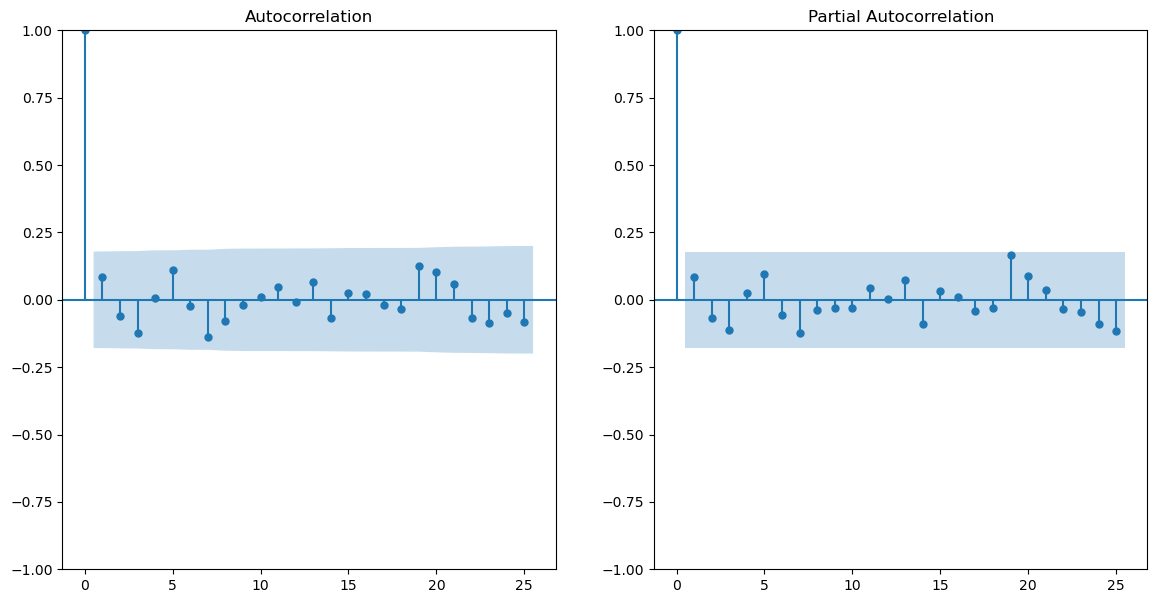

In [1653]:
plot_acf_pacf(belgium_wheat_prices['Value'], 25)

In [1654]:
X = belgium_wheat_prices['Value'].dropna().values

In [1655]:
train = X[:len(X)-7]
test = X[len(X)-7:]

model_belgium = AutoReg(train, lags=20).fit()

print(model_belgium.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  113
Model:                    AutoReg(20)   Log Likelihood                 123.538
Method:               Conditional MLE   S.D. of innovations              0.064
Date:                Mon, 12 Feb 2024   AIC                           -203.076
Time:                        16:49:17   BIC                           -147.359
Sample:                            20   HQIC                          -180.579
                                  113                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.007      1.453      0.146      -0.003       0.023
y.L1           0.0568      0.101      0.564      0.573      -0.141       0.254
y.L2          -0.0083      0.110     -0.075      0.9

In [1656]:
pred_belgium= model_belgium.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

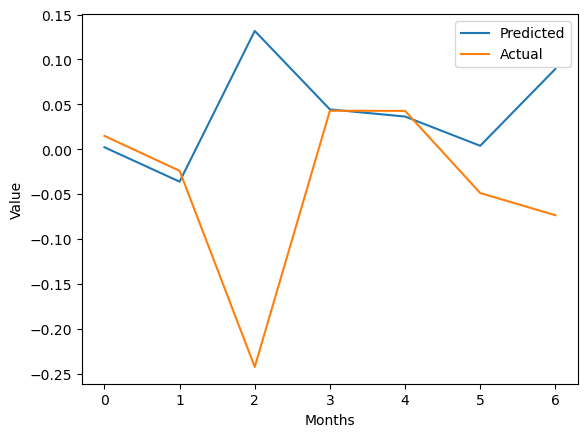

In [1657]:
# import pyplot
from matplotlib import pyplot
pyplot.plot(pred_belgium, label='Predicted')
pyplot.plot(test, label='Actual')

pyplot.xlabel('Months')
pyplot.ylabel('Value')

pyplot.legend()

In [1658]:
# Calculate the mean squared erro
rmse_belgium = rmse_calc(test, pred_belgium)
print('Test RMSE: %.3f' % rmse_belgium)

Test RMSE: 0.156


In [1659]:
# future prediction
pred_future_belgium = model_belgium.predict(start=len(X)+1, end=len(X)+24, dynamic=False)
print("The future prediction for the next 7 days is:")
print(pred_future_belgium)
print("Numbeer of predictions made: ", len(pred_future_belgium))


The future prediction for the next 7 days is:
[ 0.0403265   0.08929894  0.05092429  0.1028789  -0.00551567  0.10191588
  0.10000741  0.08844285 -0.01737587  0.10623563  0.13066633  0.10170813
 -0.00531069  0.03654125  0.12320876  0.09468013  0.05682562  0.03547096
  0.1088856   0.09577291  0.09182598  0.05560501  0.12367966  0.0904571 ]
Numbeer of predictions made:  24


In [1660]:
last_date_in_data = belgium_wheat_prices.index.max()


In [1661]:
predictions_belgium = generate_predictions(last_date_in_data, pred_future_belgium, 24, country='Spain')

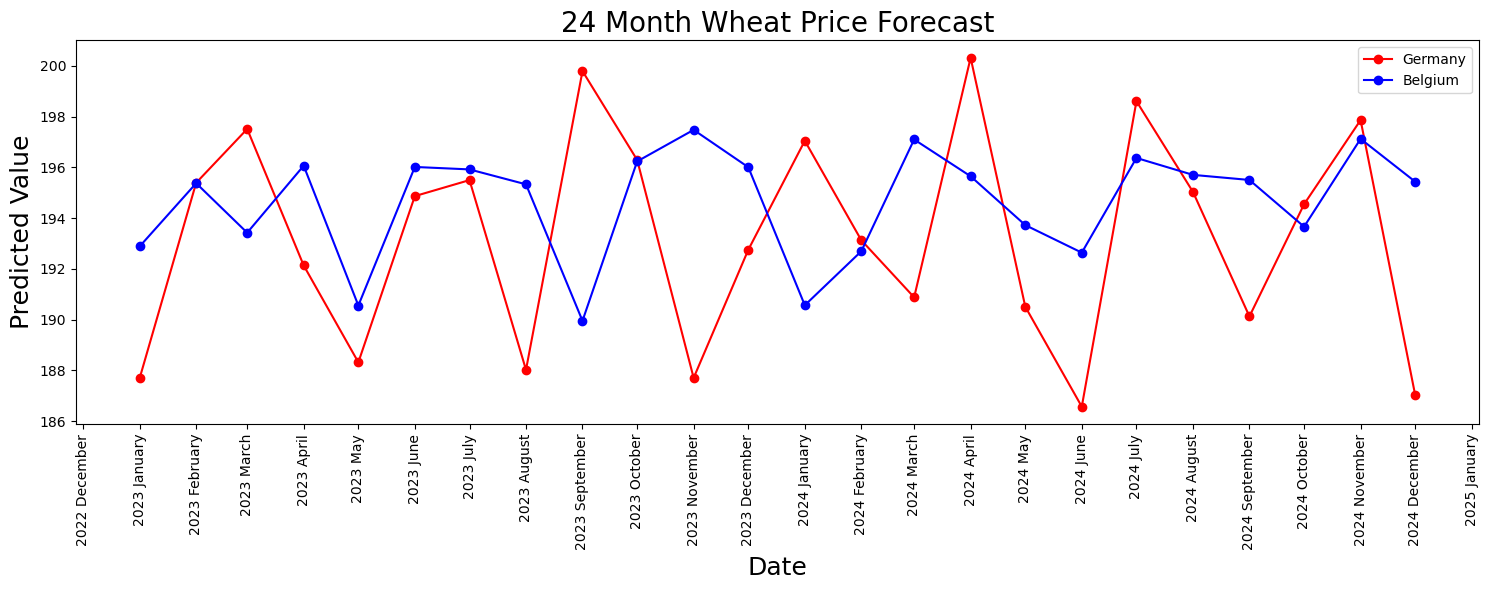

In [1664]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_predictions(predictions, title='24 Month Wheat Price Forecast', xlabel='Date', ylabel='Predicted Value'):
    # Ensure that 'predictions' has a DateTime index

    # Plot the predictions
    plt.figure(figsize=(15,6))
    for prediction, label, color in predictions:
        plt.plot(prediction.index, prediction, label=label, color=color, marker='o')

    # Define the date format
    date_format = mdates.DateFormatter('%Y %B') 
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # Add title and labels
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    # Show legend
    plt.legend()

    # Rotate the date labels for better readability
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()  
    plt.show()


predictions = [
    (predictions_germany, 'Germany', 'red'),
    (predictions_belgium, 'Belgium', 'blue')
]
plot_predictions(predictions)